In [5]:
import numpy as np
import cv2
import skimage
import matplotlib.pyplot as plt
import src.cp_hw2
# import src.cp_exr

# 1. HDR imaging

## Linearize rendered images

In [6]:
path_list = ['data/my_stack/exposure'+str(i)+'.jpg' for i in range(1,17)]
img_stack_jpg_for_g = []
for path in path_list : 
    img = plt.imread(path)
    #sample the image to reduce the size
    img = img[::200, ::200]
    img_stack_jpg_for_g.append(img)
img_stack_jpg_for_g = np.array(img_stack_jpg_for_g)
img_stack_jpg_reshaped_for_g = img_stack_jpg_for_g.reshape(img_stack_jpg_for_g.shape[0],-1).swapaxes(0,1)


In [7]:
def recover_g(imgs_stack_reshaped, images_stack, w, t, r_l=1, is_w_photon=False):
    n = 256
    num_rows = imgs_stack_reshaped.shape[0] * imgs_stack_reshaped.shape[1] + n + 1
    num_cols = n + imgs_stack_reshaped.shape[0]
    
    A = np.zeros((num_rows, num_cols))
    b = np.zeros((num_rows, 1))
    cur_row_A = 0
    
    # Populate matrix A and vector b
    for i in range(imgs_stack_reshaped.shape[0]):
        for j in range(imgs_stack_reshaped.shape[1]):
            wt_ij = w(imgs_stack_reshaped[i, j], t[j]) if is_w_photon else w(imgs_stack_reshaped[i, j])
            A[cur_row_A, imgs_stack_reshaped[i, j]] = wt_ij
            A[cur_row_A, n + i - 1] = -wt_ij
            b[cur_row_A, 0] = wt_ij * np.log(t[j])
            cur_row_A += 1
    
    # Add smoothing regularization terms
    for i in range(n):
        wt_i = 1 if is_w_photon else w(i)
        A[cur_row_A,i-1] = r_l * wt_i
        A[cur_row_A,i] = -2*r_l*wt_i
        A[cur_row_A,i+1] = r_l*wt_i
        cur_row_A += 1 
    
    # Normalize the curve
    A[cur_row_A, 128] = 1
    
    # Solve the least squares problem
    v_sol, *_ = np.linalg.lstsq(A, b, rcond=None)
    g = v_sol[:n]
    
    return g

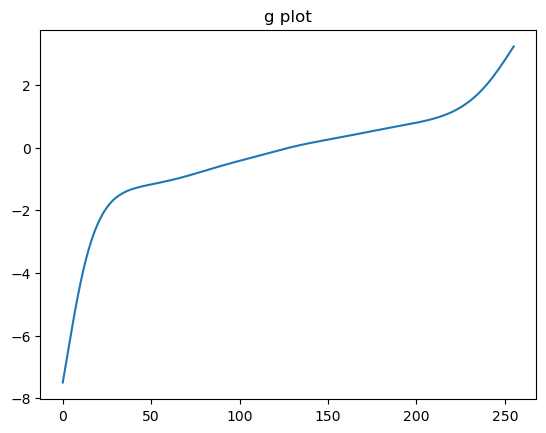

In [8]:
# Function to calculate exposure times
exptime = lambda x: 2.0 ** (x - 1 - 11)
exptime_list = [exptime(i) for i in range(1, 17)]

# Weight function
w = lambda x, zmin=0.05, zmax=0.95: 0.01

# Calculate g-values
g = recover_g(img_stack_jpg_reshaped_for_g, img_stack_jpg_for_g, w, exptime_list, 1000)

# Plotting g
plt.plot(np.arange(0,256),g)
plt.title('g plot')
plt.show()

In [14]:
# Linearizing the image
path_list = ['data/my_stack/exposure'+str(i)+'.jpg' for i in range(1,17)]
imgs_stack_jpg = []
for path in path_list : 
    img = plt.imread(path)
    img = img[::20, ::20]
    # img = img[::5, ::5]
    imgs_stack_jpg.append(img)
imgs_stack_jpg = np.array(imgs_stack_jpg)

def linearize_image(images_stack, g) : 
    lin_images_stack = np.exp(g[images_stack])
    lin_images_stack = lin_images_stack.squeeze(-1)
    return lin_images_stack

imgs_stack_linear = linearize_image(imgs_stack_jpg, g)
# plt.imshow(imgs_stack_linear[10])
# display_hdr_image(lin_images_stack[8],0.05)

## Merge exposure stack into HDR image

In [15]:
# Load the tiff images
path_list = ['data/my_stack/exposure'+str(i)+'.tiff' for i in range(1,17)]
imgs_stack_tiff = []
for path in path_list :

    img = cv2.imread(path, -1)
    img = img[...,::-1]
    img = img[::5, ::5]
    imgs_stack_tiff.append(img)
imgs_stack_tiff = np.array(imgs_stack_tiff)

# Normalize the images
imgs_stack_jpg_normalized = imgs_stack_jpg / 255.0
imgs_stack_tiff_normalized = imgs_stack_tiff / (2**16 - 1)

In [54]:
def linear_merging(img_stack, img_stack_linear, exposure_times, weight_vector, is_w_photon=False) :
    
    img_hdr_num = np.zeros(img_stack[0].shape)
    img_hdr_den = np.zeros(img_stack[0].shape)

    for k in range(len(img_stack)) :
        if is_w_photon : 
            if np.max(img_stack_linear) > 256 : 
                w_v_imk = weight_vector(img_stack[k],exposure_times[k],0.02, 0.98)
            else : 
                w_v_imk = weight_vector(img_stack[k],exposure_times[k])
        else : 
            if np.max(img_stack_linear) > 256 : 
                w_v_imk = weight_vector(img_stack[k], 0.02, 0.98)
            else : 
                w_v_imk = weight_vector(img_stack[k])
        img_hdr_num += (w_v_imk * img_stack_linear[k] / exposure_times[k] ) 
        img_hdr_den += (w_v_imk)
    
    img_hdr = img_hdr_num / img_hdr_den
    
    # if img_hdr_num == 0, img_hdr should also be zero
    img_hdr_num_zero = np.where(img_hdr_num == 0)
    if len(img_hdr_num_zero) == 3 : 
        img_hdr_num_zero = np.vstack((np.vstack((img_hdr_num_zero[0],img_hdr_num_zero[1])), img_hdr_num_zero[2])).T
    else : 
        img_hdr_num_zero = np.vstack((img_hdr_num_zero[0],img_hdr_num_zero[1])).T
        
        
    # if only img_hdr_den is zero, img_hdr should be max val
    img_hdr_den_zero = np.where(img_hdr_den == 0)
    if len(img_hdr_den_zero) == 3 : 
        img_hdr_den_zero = np.vstack((np.vstack((img_hdr_den_zero[0],img_hdr_den_zero[1])), img_hdr_den_zero[2])).T
    else : 
        img_hdr_den_zero = np.vstack((img_hdr_den_zero[0],img_hdr_den_zero[1])).T
    
    img_hdr_max_val = []
    
    if img_hdr_num_zero.size > 0 :
        if len(img_hdr.shape) == 3 : 
            img_hdr[img_hdr_num_zero[:,0],img_hdr_num_zero[:,1],img_hdr_num_zero[:,2]] = 0
        else : 
            img_hdr[img_hdr_num_zero[:,0],img_hdr_num_zero[:,1]] = 0
    
    if img_hdr_den_zero.size > 0 :
        for index in img_hdr_den_zero :
            if len(img_hdr.shape) == 3 : 
                if img_hdr_num[index[0],index[1],index[2]] != 0 :
                    img_hdr_max_val.append(index)
            else : 
                if img_hdr_num[index[0],index[1]] != 0 :
                    img_hdr_max_val.append(index)
                
        img_hdr_max_val = np.array(img_hdr_max_val).T
        if img_hdr_max_val.size > 0 :
            if len(img_hdr.shape) == 3 : 
                img_hdr[img_hdr_max_val[:,0],img_hdr_max_val[:,1],img_hdr_max_val[:,2]] = img_hdr.nanmax()
            else : 
                img_hdr[img_hdr_max_val[:,0],img_hdr_max_val[:,1]] = img_hdr.nanmax()
    
    return img_hdr


def logarithmic_merging(img_stack, img_stack_linear, exposure_times, weight_fucntion, is_w_photon=False) :
    
    eps = 1e-8
    img_hdr_num = np.zeros(img_stack[0].shape)
    img_hdr_den = np.zeros(img_stack[0].shape)

    for k in range(len(img_stack)) :        
        if is_w_photon : 
            if np.max(img_stack_linear) > 256 : 
                w_v_imk = weight_fucntion(img_stack[k],exposure_times[k],0.02, 0.98)
            else : 
                w_v_imk = weight_fucntion(img_stack[k],exposure_times[k])
        else : 
            if np.max(img_stack_linear) > 256 : 
                w_v_imk = weight_fucntion(img_stack[k], 0.02, 0.98)
            else : 
                w_v_imk = weight_fucntion(img_stack[k])
        img_hdr_num += ( w_v_imk * ( np.log(img_stack_linear[k] + eps) - np.log(exposure_times[k]))) 
        img_hdr_den += w_v_imk
        
    img_hdr = img_hdr_num / img_hdr_den

    # if img_hdr_num == 0, img_hdr should also be zero
    img_hdr_num_zero = np.where(img_hdr_num == 0)
    img_hdr_num_zero = np.vstack((np.vstack((img_hdr_num_zero[0],img_hdr_num_zero[1])), img_hdr_num_zero[2])).T
    
    # if only img_hdr_den is zero, img_hdr should be max val
    img_hdr_den_zero = np.where(img_hdr_den == 0)
    img_hdr_den_zero = np.vstack((np.vstack((img_hdr_den_zero[0],img_hdr_den_zero[1])), img_hdr_den_zero[2])).T
    img_hdr_max_val = []
    
    if img_hdr_num_zero.size > 0 :
        img_hdr[img_hdr_num_zero[:,0],img_hdr_num_zero[:,1],img_hdr_num_zero[:,2]] = 0
    
    if img_hdr_den_zero.size > 0 :
        for index in img_hdr_den_zero :
            if img_hdr_num[index[0],index[1],index[2]] != 0 :
                img_hdr_max_val.append(index)
        img_hdr_max_val = np.array(img_hdr_max_val).T
        if img_hdr_max_val.size > 0 :
            img_hdr[img_hdr_max_val[:,0],img_hdr_max_val[:,1],img_hdr_max_val[:,2]] = img_hdr.nanmax()
        
    return np.exp(img_hdr)


## Weighting schemes

In [55]:
def w_uniform(z, Z_min = 0.05, Z_max=0.95) :
    if isinstance(z,np.uint8) or isinstance(z,int): 
        z = z / 255.0
    if Z_min <= z <= Z_max :
        return 1
    return 0

def w_tent(z, Z_min = 0.005, Z_max=0.995) :
    if isinstance(z,np.uint8) or isinstance(z,int) : 
        z = z / 255.0
    Z_min = 0.001
    Z_max = 0.999
    if Z_min <= z <= Z_max :
        return np.min([z, 1.0-z])
    return 0

def w_gaussian(z, Z_min = 0.005, Z_max=0.995) :
    if isinstance(z,np.uint8) or isinstance(z,int): 
        z = z / 255.0
    Z_min = 0.001
    Z_max = 0.999
    if Z_min <= z <= Z_max :
        return np.exp(-4 * (((z-0.5)**2) / ((0.5)**2)))
    return 0

def w_photon(z, tk, Z_min = 0.01, Z_max=0.99) : 
    if isinstance(z,np.uint8) or isinstance(z,int): 
        z = z / 255.0
    if Z_min <= z <= Z_max :
        return tk
    return 0
    

In [56]:
w_uniform_vect = np.vectorize(w_uniform)
w_tent_vect = np.vectorize(w_tent)
w_gaussian_vect = np.vectorize(w_gaussian)
w_photon_vect = np.vectorize(w_photon)

In [19]:
# Merge raw images
img_hdr_tiff_lin_merged_w_uniform = linear_merging(imgs_stack_tiff_normalized, imgs_stack_tiff, exptime_list, w_uniform_vect)
img_hdr_tiff_lin_merged_w_tent = linear_merging(imgs_stack_tiff_normalized, imgs_stack_tiff, exptime_list, w_tent_vect)
img_hdr_tiff_lin_merged_w_gaussian = linear_merging(imgs_stack_tiff_normalized, imgs_stack_tiff, exptime_list, w_gaussian_vect)
img_hdr_tiff_lin_merged_w_photon = linear_merging(imgs_stack_tiff_normalized, imgs_stack_tiff, exptime_list, w_photon_vect, is_w_photon=True)

print('linear merging done')

img_hdr_tiff_log_merged_w_uniform = logarithmic_merging(imgs_stack_tiff_normalized, imgs_stack_tiff, exptime_list, w_uniform_vect)
img_hdr_tiff_log_merged_w_tent = logarithmic_merging(imgs_stack_tiff_normalized, imgs_stack_tiff, exptime_list, w_tent_vect)
img_hdr_tiff_log_merged_w_gaussian = logarithmic_merging(imgs_stack_tiff_normalized, imgs_stack_tiff, exptime_list, w_gaussian_vect)
img_hdr_tiff_log_merged_w_photon = logarithmic_merging(imgs_stack_tiff_normalized, imgs_stack_tiff, exptime_list, w_photon_vect, is_w_photon=True)

/var/folders/sx/x97pflv53g7fw_fwz8qq6xzh0000gn/T/ipykernel_92970/1769219994.py:20: RuntimeWarning: invalid value encountered in true_divide
  img_hdr = img_hdr_num / img_hdr_den


linear merging done


/var/folders/sx/x97pflv53g7fw_fwz8qq6xzh0000gn/T/ipykernel_92970/1769219994.py:84: RuntimeWarning: invalid value encountered in true_divide
  img_hdr = img_hdr_num / img_hdr_den


In [29]:
# HDR display util functions
def linear_scaling(img, scale):
    img_scaled = np.clip(img * scale, 0, 1)
    return img_scaled

def gamma_encoding(x) : 
    if x <= 0.0031308 : 
        return 12.92 * x
    else : 
        return (1+0.055) * np.power(x, 1/2.4) - 0.055

def display_hdr(img, scale, title='') : 
    img_scaled = linear_scaling(img, scale)
    gamma_encoding_vect = np.vectorize(gamma_encoding)
    image_ge = gamma_encoding_vect(img_scaled)

    plt.imshow(image_ge)
    plt.title(title)
    plt.show()

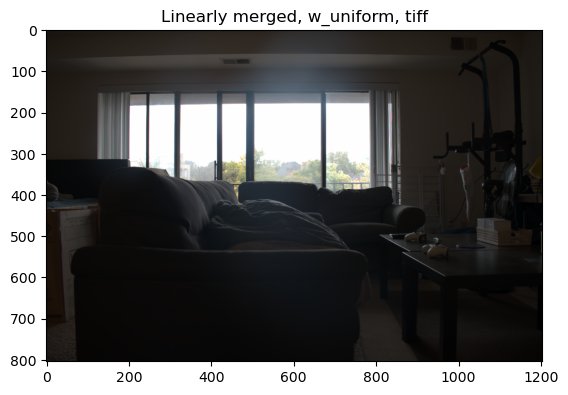

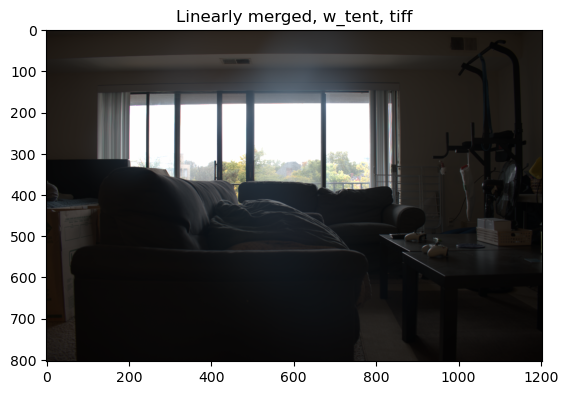

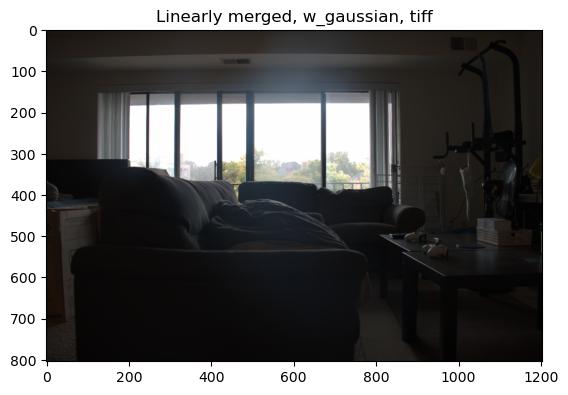

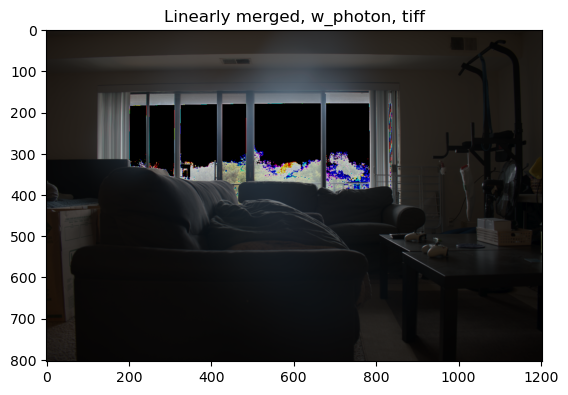

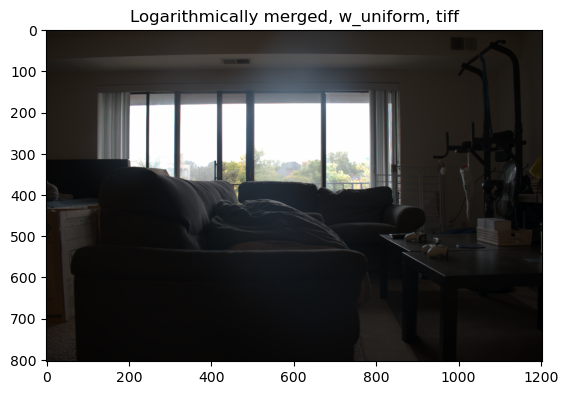

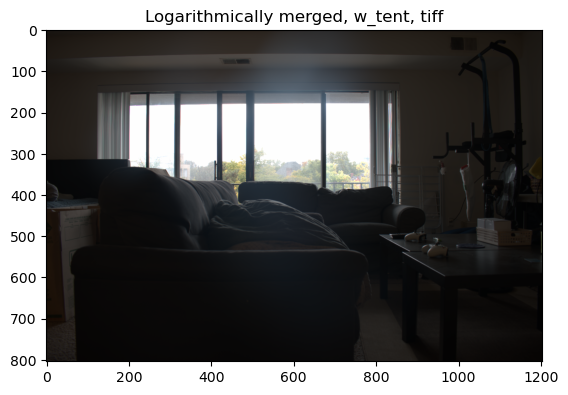

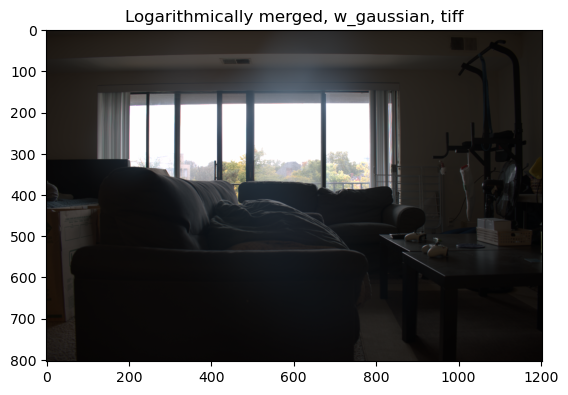

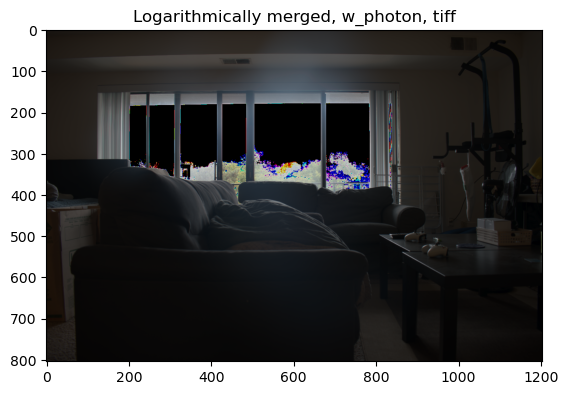

In [30]:
# Display tiff hdr images
display_hdr(img_hdr_tiff_lin_merged_w_uniform,0.00001,'Linearly merged, w_uniform, tiff')
display_hdr(img_hdr_tiff_lin_merged_w_tent,0.00001,'Linearly merged, w_tent, tiff')
display_hdr(img_hdr_tiff_lin_merged_w_gaussian,0.00001,'Linearly merged, w_gaussian, tiff')
display_hdr(img_hdr_tiff_lin_merged_w_photon,0.00001,'Linearly merged, w_photon, tiff')

display_hdr(img_hdr_tiff_log_merged_w_uniform,0.00001,'Logarithmically merged, w_uniform, tiff')
display_hdr(img_hdr_tiff_log_merged_w_tent,0.00001,'Logarithmically merged, w_tent, tiff')
display_hdr(img_hdr_tiff_log_merged_w_gaussian,0.00001,'Logarithmically merged, w_gaussian, tiff')
display_hdr(img_hdr_tiff_log_merged_w_photon,0.00001,'Logarithmically merged, w_photon, tiff')


In [31]:
# First linearlize then Merge jpg images
g_uniform = recover_g(img_stack_jpg_reshaped_for_g, img_stack_jpg_for_g, w_uniform_vect,exptime_list, 1000)
g_tent = recover_g(img_stack_jpg_reshaped_for_g, img_stack_jpg_for_g, w_tent_vect,exptime_list, 1000)
g_gaussian = recover_g(img_stack_jpg_reshaped_for_g, img_stack_jpg_for_g, w_gaussian_vect,exptime_list, 1000)
g_photon = recover_g(img_stack_jpg_reshaped_for_g, img_stack_jpg_for_g, w_photon_vect,exptime_list, 1000, is_w_photon=True)

imgs_linear_stack_uniform = linearize_image(imgs_stack_jpg, g_uniform)
imgs_linear_stack_tent = linearize_image(imgs_stack_jpg, g_tent)
imgs_linear_stack_gaussian = linearize_image(imgs_stack_jpg, g_gaussian)
imgs_linear_stack_photon = linearize_image(imgs_stack_jpg, g_photon)


In [32]:
img_hdr_jpeg_lin_merged_w_uniform = linear_merging(imgs_stack_jpg_normalized, imgs_linear_stack_uniform, exptime_list, w_uniform_vect)
img_hdr_jpeg_lin_merged_w_tent = linear_merging(imgs_stack_jpg_normalized, imgs_linear_stack_tent, exptime_list, w_tent_vect)
img_hdr_jpeg_lin_merged_w_gaussian = linear_merging(imgs_stack_jpg_normalized, imgs_linear_stack_gaussian, exptime_list, w_gaussian_vect)
img_hdr_jpeg_lin_merged_w_photon = linear_merging(imgs_stack_jpg_normalized, imgs_linear_stack_photon, exptime_list, w_photon_vect, is_w_photon=True)

img_hdr_jpeg_log_merged_w_uniform = logarithmic_merging(imgs_stack_jpg_normalized, imgs_linear_stack_uniform, exptime_list, w_uniform_vect)
img_hdr_jpeg_log_merged_w_tent = logarithmic_merging(imgs_stack_jpg_normalized, imgs_linear_stack_tent, exptime_list, w_tent_vect)
img_hdr_jpeg_log_merged_w_gaussian = logarithmic_merging(imgs_stack_jpg_normalized, imgs_linear_stack_gaussian, exptime_list, w_gaussian_vect)
img_hdr_jpeg_log_merged_w_photon = logarithmic_merging(imgs_stack_jpg_normalized, imgs_linear_stack_photon, exptime_list, w_photon_vect, is_w_photon=True)

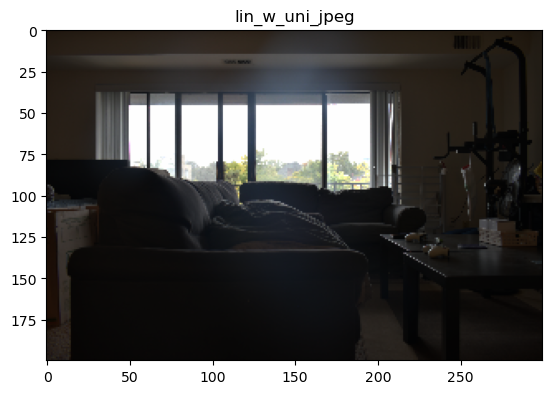

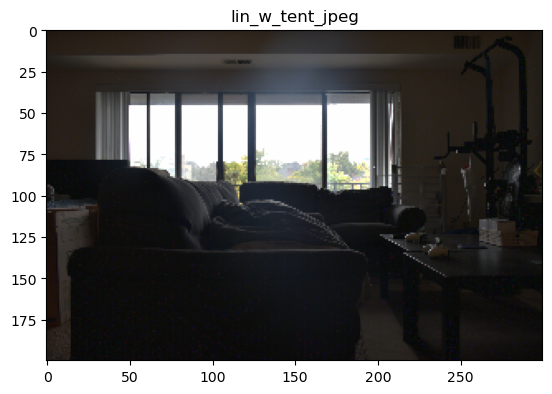

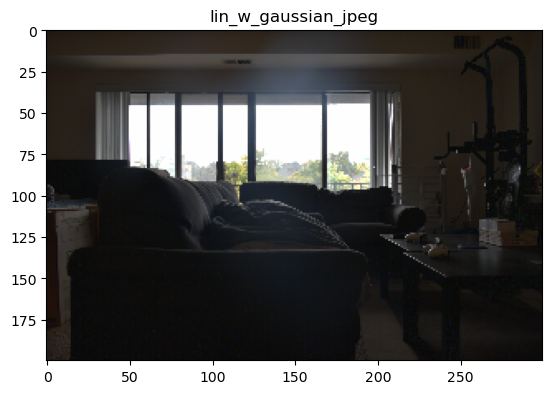

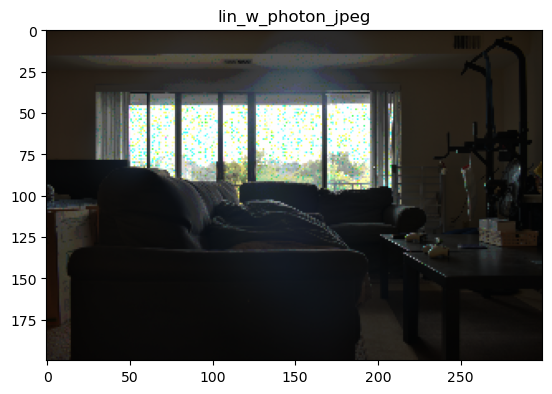

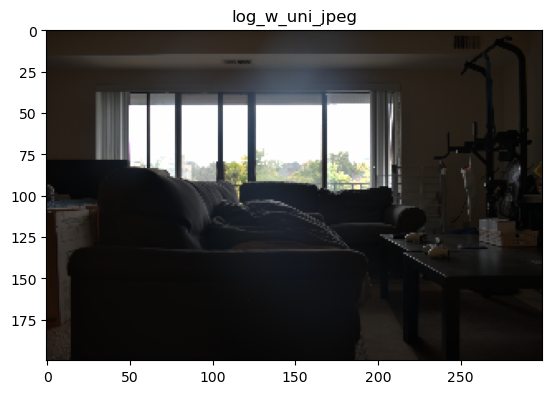

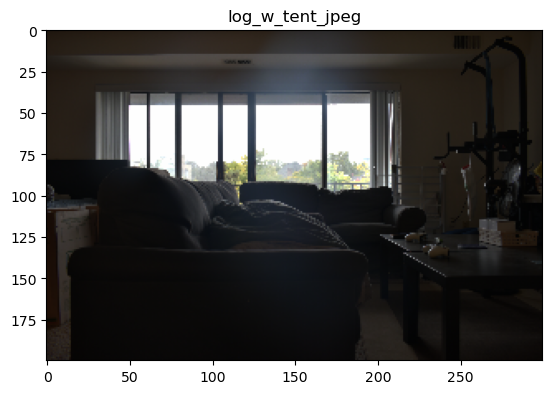

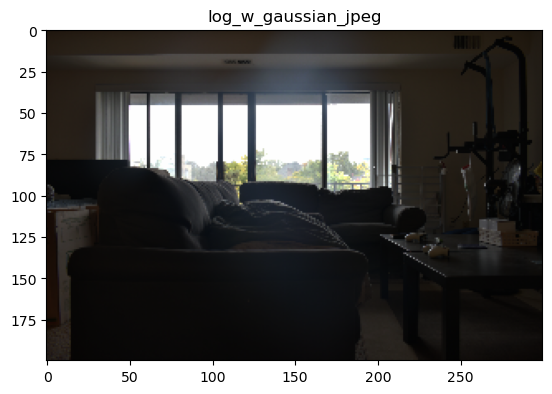

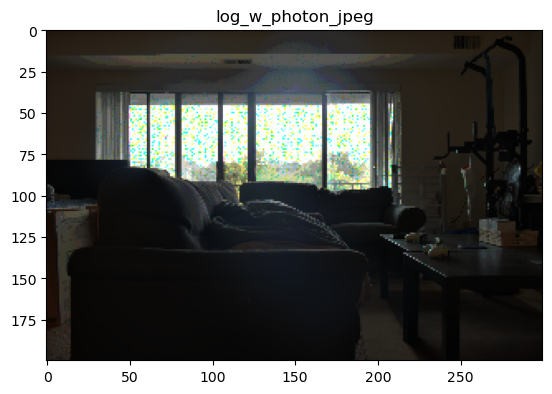

In [33]:
display_hdr(img_hdr_jpeg_lin_merged_w_uniform,0.05,'lin_w_uni_jpeg')
display_hdr(img_hdr_jpeg_lin_merged_w_tent,0.05,'lin_w_tent_jpeg')
display_hdr(img_hdr_jpeg_lin_merged_w_gaussian,0.05,'lin_w_gaussian_jpeg')
display_hdr(img_hdr_jpeg_lin_merged_w_photon,0.05,'lin_w_photon_jpeg')

display_hdr(img_hdr_jpeg_log_merged_w_uniform,0.05,'log_w_uni_jpeg')
display_hdr(img_hdr_jpeg_log_merged_w_tent,0.05,'log_w_tent_jpeg')
display_hdr(img_hdr_jpeg_log_merged_w_gaussian,0.05,'log_w_gaussian_jpeg')
display_hdr(img_hdr_jpeg_log_merged_w_photon,0.05,'log_w_photon_jpeg')

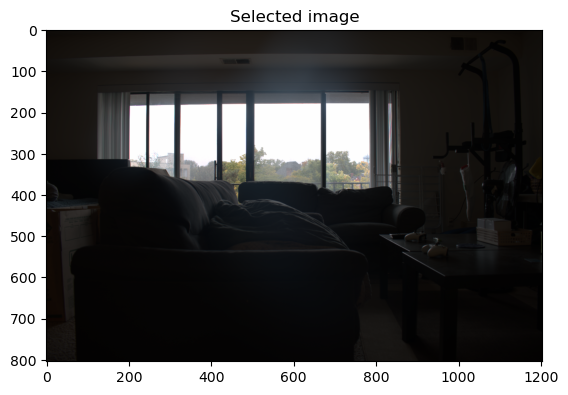

In [35]:
# Copy the selected HDR image for further processing
img_hdr_selected = img_hdr_tiff_lin_merged_w_gaussian.copy()

# Display the selected HDR image
display_hdr(img_hdr_selected, 0.000005, 'Selected image')


# 3. Photographic tonemapping

In [36]:
# Define functions for tonemapping
def get_I_m_hdr(img) : 
    if img.min() < 0 : 
        # clipping out negative values and raising them to be over 0
        I_m_hdr = np.exp(np.log(img - (1.00000001) * img.min()).mean()) 
    else : 
        # else 
        I_m_hdr = np.exp(np.log(img + 1e5).mean()) 
    
    return I_m_hdr

def get_I_tilda_ij_hdr(I_m_hdr, im, K) : 
    I_tilda_ij_hdr= K * (im) / I_m_hdr
    return I_tilda_ij_hdr

def get_I_tilda_white(I_tilda_ij_hdr, B) : 
    I_tilda_white = B * np.max(I_tilda_ij_hdr)
    return I_tilda_white

def phtographic_tonemapping(img, K, B) :
    
    I_m_hdr = get_I_m_hdr(img)
    I_tilda_ij_hdr = get_I_tilda_ij_hdr(I_m_hdr, img, K)
    I_tilda_white = get_I_tilda_white(I_tilda_ij_hdr, B)
    
    img_tonemapped_num = I_tilda_ij_hdr * (1 + I_tilda_ij_hdr / (I_tilda_white**2))
    img_tonemapped_den = 1 + I_tilda_ij_hdr
    
    img_tonemapped = img_tonemapped_num / img_tonemapped_den
    
    return img_tonemapped

def photographic_tonemapping_xyY(img, K, B) :
    
    img_XYZ = src.cp_hw2.lRGB2XYZ(img)
    x = img_XYZ[...,0] / img_XYZ.sum(2) 
    y = img_XYZ[...,1] / img_XYZ.sum(2)
    Y = img_XYZ[...,1]
    
    Y_tonemapped = phtographic_tonemapping(Y, K, B)
    
    X = (x * Y_tonemapped) / y
    Y = Y_tonemapped
    Z = (1 - x - y) * Y_tonemapped / y
    
    img_XYZ_tonemapped = np.concatenate((np.stack((X,Y),-1),np.expand_dims(Z,-1)),-1)   
    img_RGB_tonemapped = src.cp_hw2.XYZ2lRGB(img_XYZ_tonemapped)
    
    return img_RGB_tonemapped

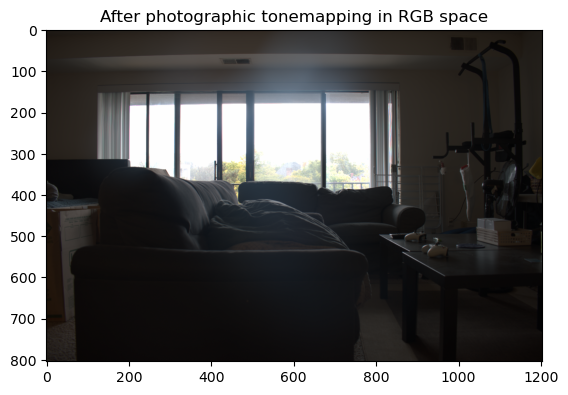

In [53]:
img_hdr_selected_cc_wb_ptm = phtographic_tonemapping(img_hdr_selected, K=0.1, B=1)
display_hdr(img_hdr_selected_cc_wb_ptm, 15, 'After photographic tonemapping in RGB space')

# img_hdr_selected_cc_wb_ptm_xyY = photographic_tonemapping_xyY(img_hdr_selected, K=0.18, B=0.01)
# display_hdr(img_hdr_selected_cc_wb_ptm_xyY, 0.01, 'After photographic tonemapping in xyY')

In [57]:
src.cp_hw2.writeHDR('output/part4.hdr', img_hdr_selected_cc_wb_ptm)